## Carga del entorno

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import json
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib inline

In [41]:
#Variables globales
global df_banco,resultados
#Cargamos el datframe, si hay espacios en blanco los eliminamos
dataframe=pd.read_csv('german_credit (1).csv').apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df_banco=dataframe.copy()

In [4]:
#Verificación de carga correcta de bibliotecas
!python -V
print('------')
!pip show Pandas | findstr "Name Version"
print('------')
!pip show Matplotlib | findstr "Name Version"

Python 3.9.13
------
Name: pandas------

Version: 1.4.4
Name: matplotlib
Version: 3.5.2


In [43]:
#Analizamos el dataframe
df_banco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   default                     1000 non-null   int64 
 1   account_check_status        1000 non-null   object
 2   duration_in_month           1000 non-null   int64 
 3   credit_history              1000 non-null   object
 4   purpose                     1000 non-null   object
 5   credit_amount               1000 non-null   int64 
 6   savings                     1000 non-null   object
 7   present_emp_since           1000 non-null   object
 8   installment_as_income_perc  1000 non-null   int64 
 9   personal_status_sex         1000 non-null   object
 10  other_debtors               1000 non-null   object
 11  present_res_since           1000 non-null   int64 
 12  property                    1000 non-null   object
 13  age                         1000 non-null   int64

## Limpieza de datos

In [44]:
#Función para borrar duplicados, y valores nulos, ademas convierte los datos categoricos en datos numericos
def procesar_datos():
    global df_banco,resultados
    
    # Eliminar duplicados basados en todas las columnas
    df_banco = df_banco.drop_duplicates(subset=df_banco.columns)
    
    #Eliminamos datos nulos
    df_banco = df_banco.dropna()
    
    #Cambiaremos los datos categoricos a numericos
    #Crear un diccionario de correspondencia
    correspondencia_dict = {}

    # Iterar sobre las columnas categóricas
    for columna in df_banco.select_dtypes(include='object').columns:
        #Guardamos los datos unicos
        valores_unicos = df_banco[columna].unique()
        #Cada clave del diccionario, tendra un diccionario con la relación categorica y numerica
        mapeo = {valor: i + 1 for i, valor in enumerate(valores_unicos)}
        correspondencia_dict[columna] = mapeo
    
    # Convertir el diccionario a una cadena de texto con formato JSON
    json_str = json.dumps(correspondencia_dict, indent=2)  # indent=2 para una presentación más legible

    # Guardar la cadena de texto JSON en un archivo
    with open('diccionario_correspondencia.txt', 'w') as file:
        file.write(json_str)

    # Aplicar el mapeo a cada columna del DataFrame
    for columna, mapeo in correspondencia_dict.items():
        df_banco[columna] = df_banco[columna].map(mapeo)

# Llamada a la función para procesar datos
procesar_datos()
df_banco.head(10)

,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,1,6,1,1,1169,1,1,4,1,...,4,1,67,1,1,2,1,1,1,1
1,1,2,48,2,1,5951,2,2,2,2,...,2,1,22,1,1,1,1,1,2,1
2,0,3,12,1,2,2096,2,3,2,1,...,3,1,49,1,1,1,2,2,2,1
3,0,1,42,2,3,7882,2,3,2,1,...,4,2,45,1,2,1,1,2,2,1
4,1,1,24,3,4,4870,2,2,3,1,...,4,3,53,1,2,2,1,2,2,1
5,0,3,36,2,2,9055,1,2,2,1,...,4,3,35,1,2,1,2,2,1,1
6,0,3,24,2,3,2835,3,1,3,1,...,4,2,53,1,1,1,1,1,2,1
7,0,2,36,2,5,6948,2,2,2,1,...,2,4,35,1,3,1,3,1,1,1
8,0,3,12,2,1,3059,4,3,2,3,...,4,1,61,1,1,1,2,1,2,1
9,1,2,30,1,4,5234,2,4,4,4,...,2,4,28,1,1,2,3,1,2,1


## EDA
### Análisis exploratorio de datos

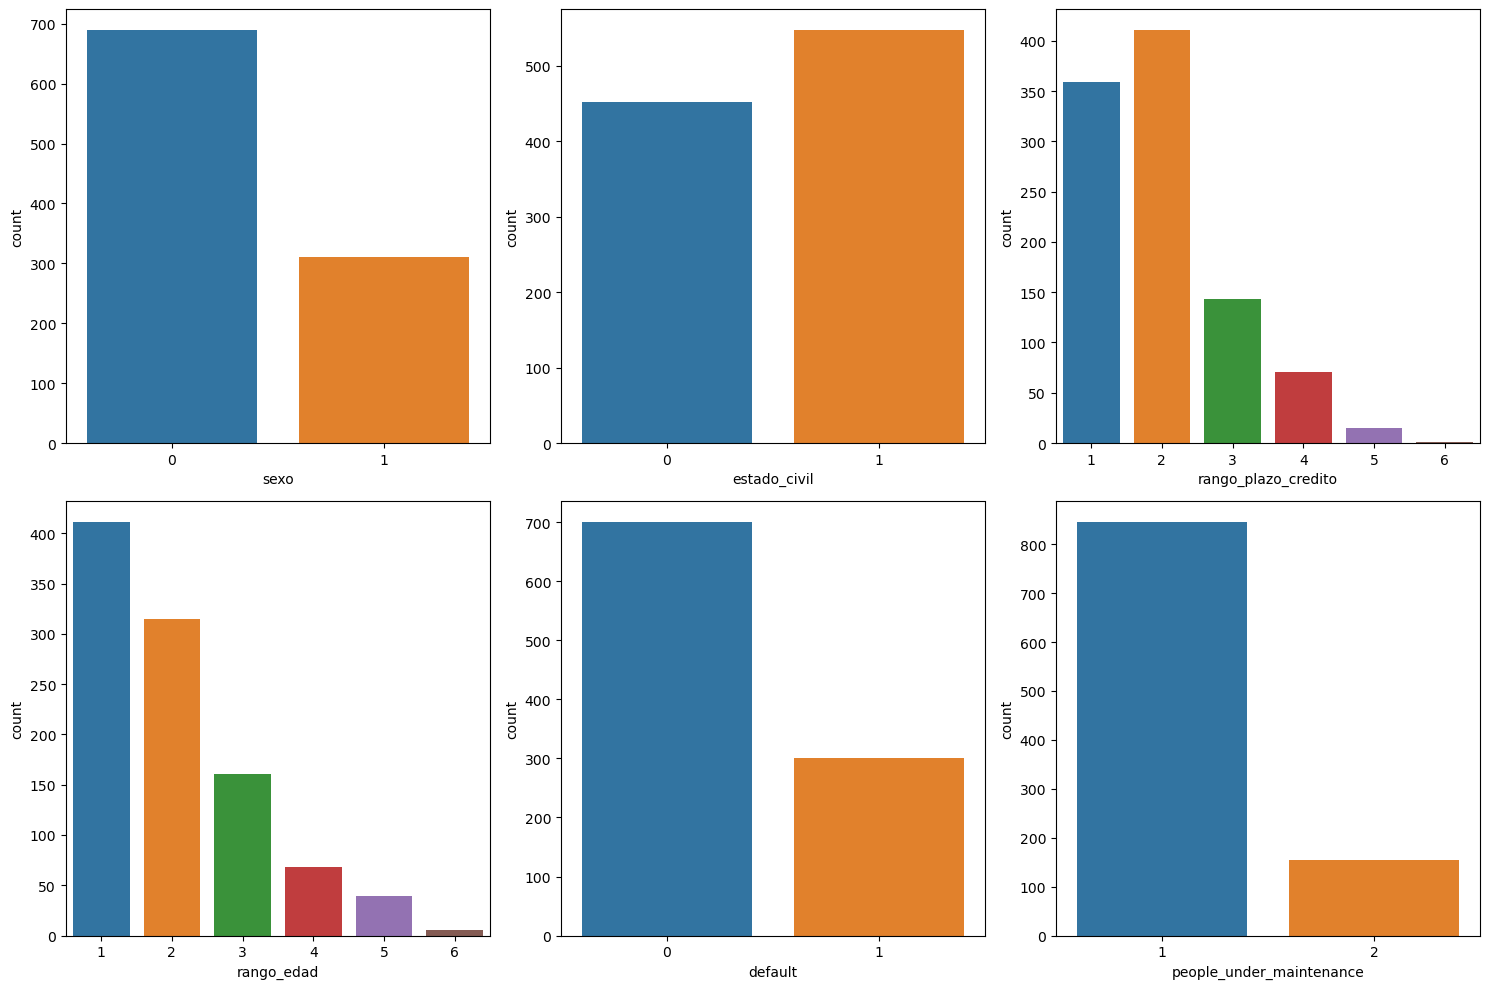

In [45]:
def feature_engineering():
    global df_banco,resultados
    #Crearemos columna de sexo, apoyandonos de nuestro diccionario creado
    sexo_list=df_banco['personal_status_sex'].unique()
    mapeo = {i:1 if i==2 else 0 for i in sexo_list}
    df_banco['sexo'] = df_banco['personal_status_sex'].map(mapeo)
    
    #Creamos nueva variable estado civil, apoyandonos de sexo_list
    mapeo={i:1 if i==1 else 0 for i in sexo_list}
    df_banco['estado_civil']= df_banco['personal_status_sex'].map(mapeo)
    
    #Creamos variable rango_edad, con esta podemos crear intervalos de edades
    df_banco['rango_edad'] = pd.cut(x=df_banco['age'], bins=[18, 30, 40, 50, 60, 70, 80], labels=[1, 2, 3, 4, 5, 6])
    
    #Rango de tiempo en el que ha pagado su credito
    df_banco['rango_plazo_credito']=pd.cut(x=df_banco['duration_in_month'],bins=[1,12,24,36,48,60,72],labels=[1,2,3,4,5,6])
    #Rango de valor
    df_banco['rango_valor_credito']=pd.cut(x=df_banco['credit_amount'],bins=[1]+[i*1000 for i in range(1,21)],labels=range(1,21))
    #Borramos elementos no necesarios
    df_banco=df_banco.drop(['personal_status_sex','age','duration_in_month','credit_amount'],axis=1)
    
    #Visualizamos en histogramas las columnas de 'sexo','estado_civil','rango_plazos_credito','rango_edad','default'
    
    # Creamos subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 filas x 3 columnas

    # Visualizamos en histogramas las columnas
    sns.countplot(x='sexo', data=df_banco, ax=axes[0, 0])
    sns.countplot(x='estado_civil', data=df_banco, ax=axes[0, 1])
    sns.countplot(x='rango_plazo_credito', data=df_banco, ax=axes[0, 2])
    sns.countplot(x='rango_edad', data=df_banco, ax=axes[1, 0])
    sns.countplot(x='default', data=df_banco, ax=axes[1, 1])
    sns.countplot(x='people_under_maintenance', data=df_banco, ax=axes[1, 2])
    # Ajustamos el diseño
    fig.tight_layout()

    # Mostramos los gráficos
    plt.show()
feature_engineering()

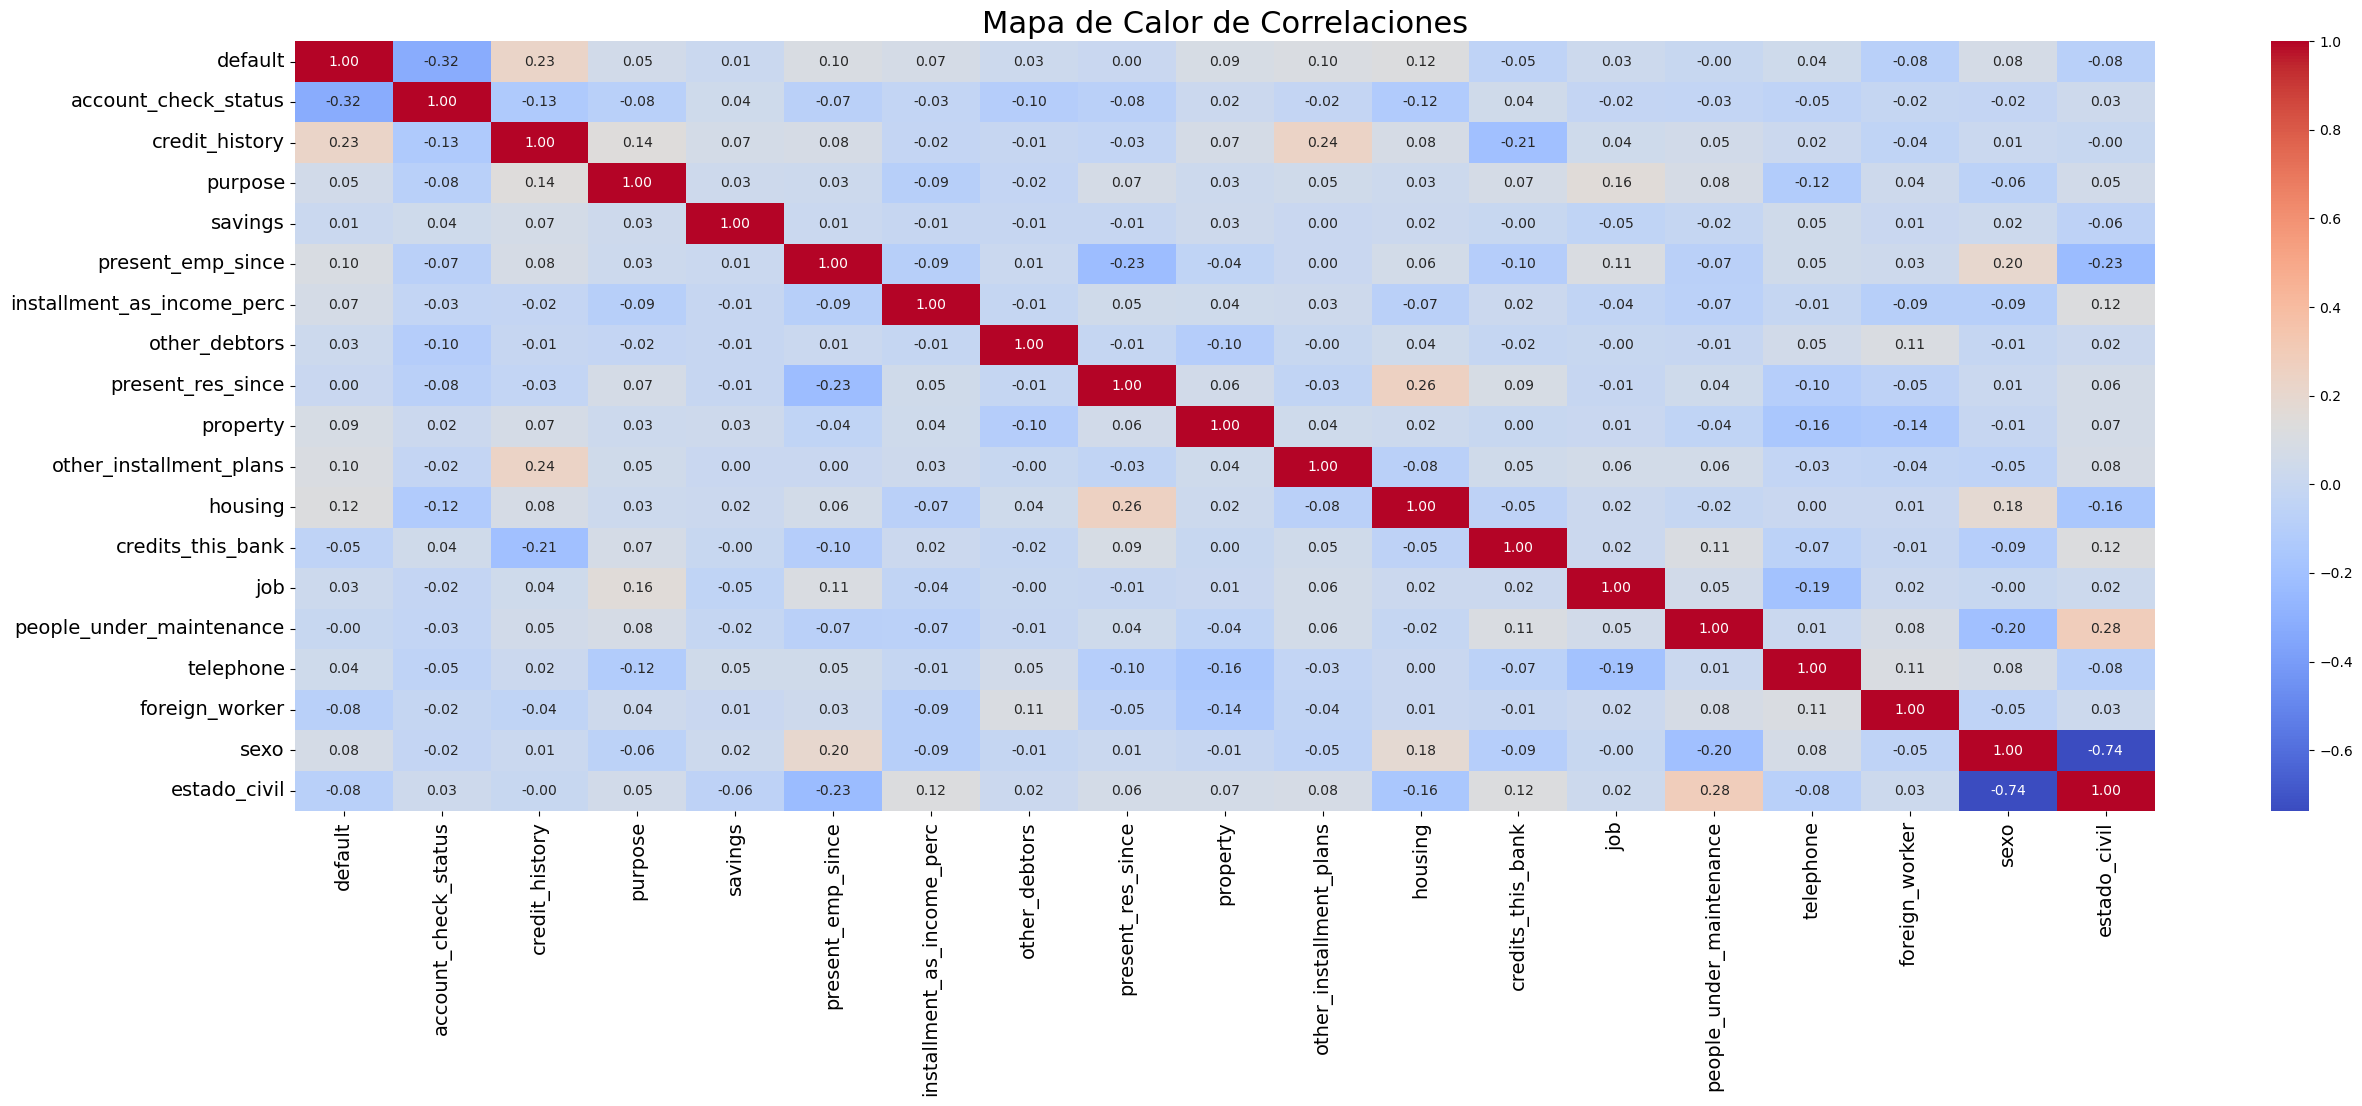

In [46]:
#Realizamos  mapa de calor para ver la correlación entre las variables

plt.figure(figsize=(30, 10))
heatmap = sns.heatmap(df_banco.corr(), annot=True, cmap='coolwarm', fmt=".2f")
heatmap.tick_params(axis='both', which='major', labelsize=14)
plt.title('Mapa de Calor de Correlaciones', fontsize=22)
plt.show()

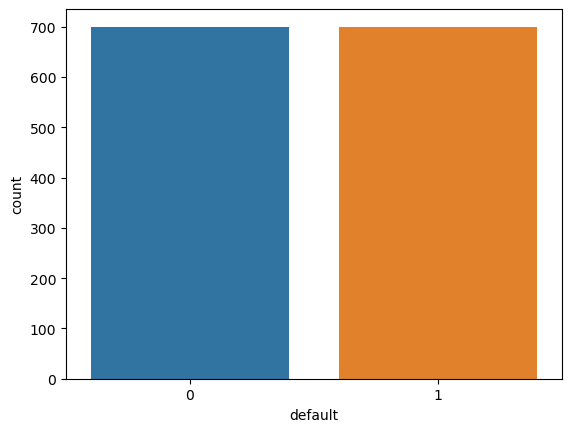

In [47]:
#Dividimos los datos en caracteristicas y target
X=df_banco.drop(['default'],axis=1)
Y=df_banco['default']

#Creamos un objeto smote
smt=SMOTE(random_state=123)
X,Y= smt.fit_resample(X,Y)

#Concatenamos los datos
df_banco = pd.concat([X,Y],axis=1) 

#Observamos el histograma para ver si ya se encuentran bien balanceados


ax = sns.countplot(x='default',data=df_banco)




In [48]:
df_banco.default.value_counts()
#Observamos un desvalanceamiento en los datos de default, por lo que los balancearemos

0    700
1    700
Name: default, dtype: int64

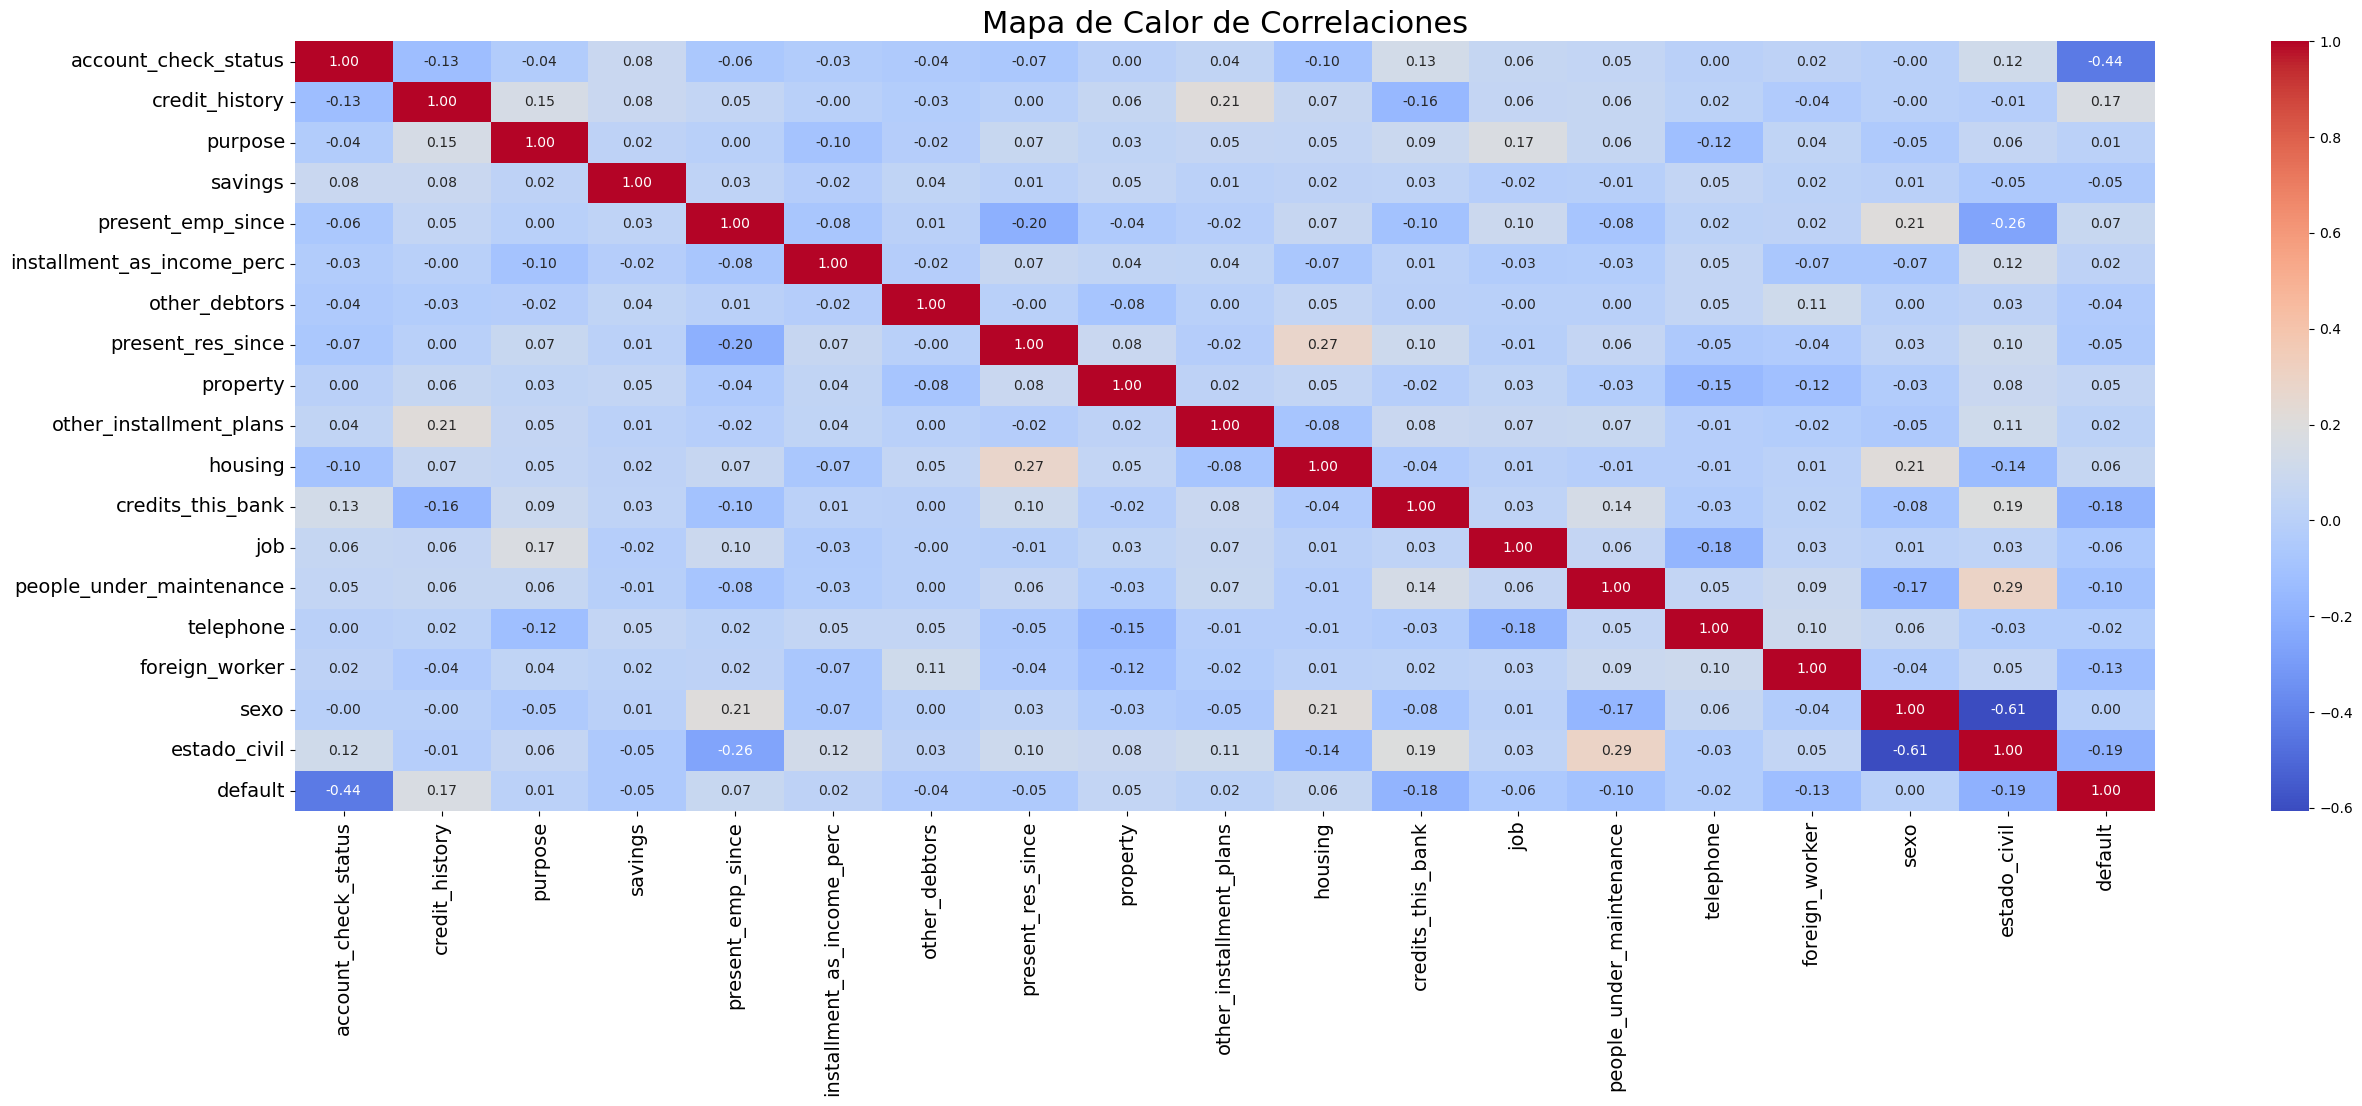

In [52]:
#Realizamos  mapa de calor para ver la correlación entre las variables

plt.figure(figsize=(30, 10))
heatmap = sns.heatmap(df_banco.corr(), annot=True, cmap='coolwarm', fmt=".2f")
heatmap.tick_params(axis='both', which='major', labelsize=14)
plt.title('Mapa de Calor de Correlaciones', fontsize=22)
plt.show()

C:\Users\luisf\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


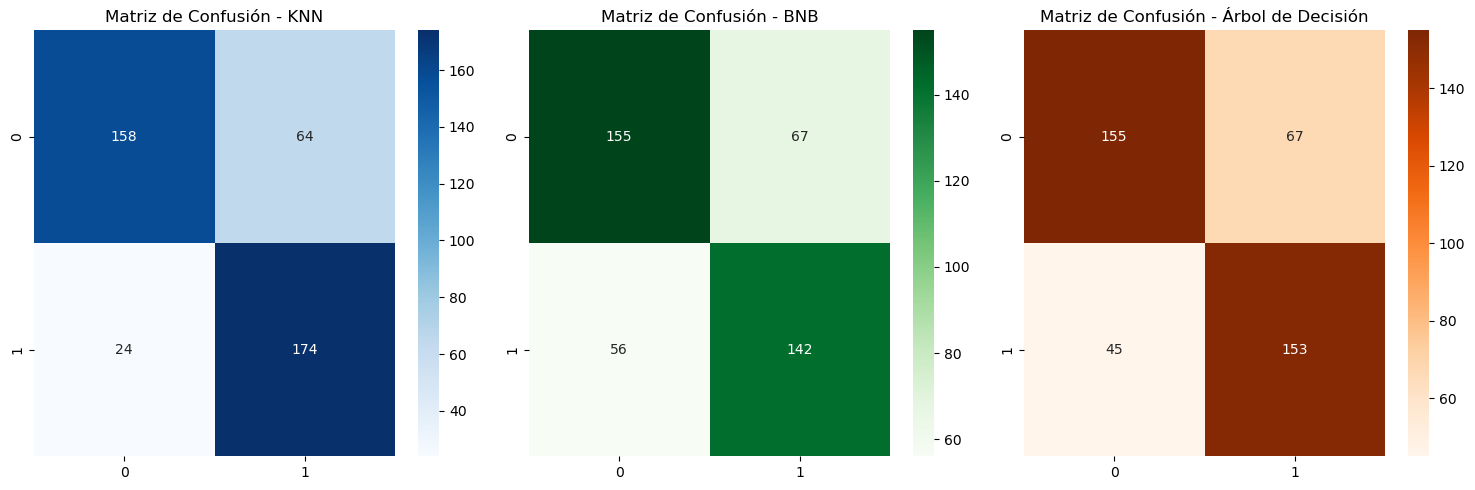

In [49]:
def crea_modelos():
    global df_banco,resultados
    
    
    #Dividimos los datos en entrenamiento y prueba
    Y = df_banco['default']
    X = df_banco.drop(columns='default')
    
    #Normalizamos los datos
    norm = StandardScaler()
    X_normalizado = norm.fit_transform(X)    
    train_x, test_x, train_y, test_y = train_test_split(X_normalizado, Y, test_size=0.30, random_state = 77)
    
    #--------------------------------------------------------------------------------------#
    #Primer model: KNN con metrica euclidiana
    
    knn=KNeighborsClassifier(metric='euclidean')
    #Entrenamos el modelo 
    knn.fit(train_x,train_y)
    #Realizamos las poredicciones
    prediccion_knn=knn.predict(test_x)
    
    
    #---------------------------------------------------------------------------------------#
    #Segundo modelo :Naive-Bayes-Bernoulli
    
    #Como usamos un modelo bernoullli, binarizamos los datos
    train_x_binarizado = np.where(train_x>np.median(train_x),1,0)
    
    #Entrenamos y probamos modelo
    bnb= BernoulliNB()
    bnb.fit(train_x_binarizado,train_y)
    #Hacemos el conjunto de test binarizado
    test_x_binarizado= np.where(test_x>np.median(test_x),1,0)
    prediccion_bnb=bnb.predict(test_x_binarizado)
    
    
    #---------------------------------------------------------------------------------------#
    #Tercer modelo: Arboles de decisión
    
    dtc= DecisionTreeClassifier(criterion='entropy',random_state=42)
    dtc.fit(train_x,train_y)
    prediccion_arbol=dtc.predict(test_x)
    
    #----------------------------------------------------------------------------------------#
    
    #Validación de los modelos con accuracy, recall, precisión,F1-Score
    accuracy=[accuracy_score(test_y,prediccion_knn),accuracy_score(test_y,prediccion_bnb),accuracy_score(test_y,prediccion_arbol)]
    sensibilidad=[recall_score(test_y,prediccion_knn),recall_score(test_y,prediccion_bnb),recall_score(test_y,prediccion_arbol)]
    precision=[precision_score(test_y,prediccion_knn),precision_score(test_y,prediccion_bnb),precision_score(test_y,prediccion_arbol)]
    F1_score=[f1_score(test_y,prediccion_knn),f1_score(test_y,prediccion_bnb),f1_score(test_y,prediccion_arbol)]
    auc_roc=[roc_auc_score(test_y,prediccion_knn),roc_auc_score(test_y,prediccion_bnb),roc_auc_score(test_y,prediccion_arbol)]
    
    #-------Ploteamos matriz de cofusión-----#
    cm_knn = confusion_matrix(test_y, prediccion_knn)
    cm_BNb = confusion_matrix(test_y, prediccion_bnb)
    cm_Arboldecision = confusion_matrix(test_y, prediccion_arbol)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Matriz de confusión - KNN
    sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title('Matriz de Confusión - KNN')

    # Matriz de confusión - BNB
    sns.heatmap(cm_BNb, annot=True, fmt="d", cmap="Greens", ax=axes[1])
    axes[1].set_title('Matriz de Confusión - BNB')

    # Matriz de confusión - Árbol de Decisión
    sns.heatmap(cm_Arboldecision, annot=True, fmt="d", cmap="Oranges", ax=axes[2])
    axes[2].set_title('Matriz de Confusión - Árbol de Decisión')
    

    # Ajusta el diseño de los subplots
    plt.tight_layout()

    # Muestra los gráficos
    plt.show()
    
    #Regresamos diccionario con todas las metricas de los modelos
    resultados={
        'Nombre_Modelo': ['KNN','BNb','Arbol Decisión'],
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': sensibilidad,
        'F1_Score': F1_score,
        'AUC_ROC': auc_roc   
        }     
crea_modelos()


    

C:\Users\luisf\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(
C:\Users\luisf\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\style.py:123: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


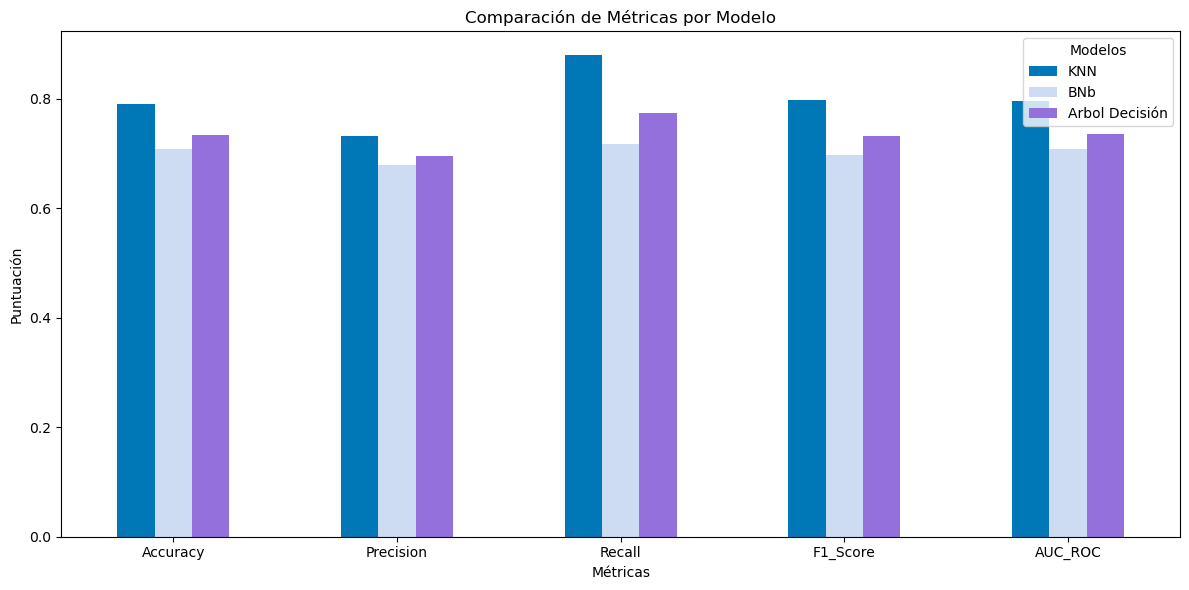

In [50]:
#Visualización de la metrica con data frame e histograma

results_df=pd.DataFrame(resultados)
results_df.set_index('Nombre_Modelo', inplace=True)

results_df = results_df.T
colors = ['#0077b6', '#CDDBF3','#9370DB', '#DDA0DD']
results_df.plot(kind='bar', figsize=(12, 6), colormap='viridis', rot=0, color=colors)
plt.title('Comparación de Métricas por Modelo')
plt.xlabel('Métricas')
plt.ylabel('Puntuación')
plt.legend(title='Modelos')
plt.tight_layout()
plt.show()

In [51]:
#Imprimimos el dataframe
results_df.head(15)

Nombre_Modelo,KNN,BNb,Arbol Decisión
Accuracy,0.790476,0.707143,0.733333
Precision,0.731092,0.679426,0.695455
Recall,0.878788,0.717172,0.772727
F1_Score,0.798165,0.697789,0.732057
AUC_ROC,0.795250,0.707685,0.735463
